In [1]:
from dataclasses import dataclass
from datasets import load_dataset
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch.utils.data import TensorDataset
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
import math
import os
from tqdm.auto import tqdm
from torchvision import transforms
import tqdm 

torch.manual_seed(0)

In [2]:
@dataclass
class TrainingConfig:
    '''
    Class for training parameters
    '''
    
    image_size = 128  # the generated image resolution
    train_batch_size = 8
    eval_batch_size = 8  # how many images to sample during evaluation
    num_epochs = 200
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [3]:
# Load the pickle files using the exact file paths
y_data_path = "/home/maddie/Documents/underwater/DeepCFD/dataY.pkl"
with open(y_data_path, "rb") as f:
    y = pickle.load(f)

In [4]:
# Preprocess the data

# turn the input in a pytorch tensor

y = torch.FloatTensor(y)

# Shuffle data 
indices = list(range(len(y)))
np.random.shuffle(indices)

y = y[indices]

# Normalize the data [-1,1] for each channel 
def normalize_tensor(tensor):
    min_val = torch.amin(tensor, dim=(0, 2, 3), keepdim=True)  # min over all axes except channels
    max_val = torch.amax(tensor, dim=(0, 2, 3), keepdim=True)  # max over all axes except channels
    # Normalize to [-1, 1]
    tensor_normalized = 2 * ((tensor - min_val) / (max_val - min_val)) - 1
    return tensor_normalized

# normalize the input and output data
y = normalize_tensor(y)




In [5]:
_, _, H, W = y.shape

postprocess = transforms.Compose(
        [
            transforms.Resize((H,W)),
            # transforms.RandomHorizontalFlip(),
            # transforms.ToTensor(),
            # transforms.Normalize([0.5], [0.5]),
        ]
    )

In [6]:

# Function for dividing the dataset 
def split_tensors(*tensors, ratio):
    preprocess = transforms.Compose(
        [
            transforms.Resize((128,128)),
            transforms.RandomHorizontalFlip(),
            # transforms.ToTensor(),
            # transforms.Normalize([0.5], [0.5]),
        ]
    )

    assert len(tensors) > 0
    split1, split2 = [], []
    count = len(tensors[0])
    for tensor in tensors:
        assert len(tensor) == count
        # Interpreting the last two dimensions as 128
        tensor = [preprocess(temp) for temp in tensor]
        tensor = torch.stack(tensor)
        split1.append(tensor[:int(len(tensor) * ratio)])
        split2.append(tensor[int(len(tensor) * ratio):])
    if len(tensors) == 1:
        split1, split2 = split1[0], split2[0]
    return split1, split2

# # Split the data into training and testing sets (70/30)
# train_data, test_data = split_tensors(x,y, ratio=0.7)
train_data, test_data = split_tensors(y,ratio=0.7)

# Create PyTorch datasets 
train_dataset = TensorDataset(train_data)

val_dataset = TensorDataset(test_data)
# test_x, test_y = test_data[:] # split test data into x and y

# Load data into PyTorch DataLoader
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config.train_batch_size, shuffle=True)


In [7]:
# Create Scheduler 
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # DDPM scheduler with 1000 timesteps

In [8]:
# Setup NN model
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

weight_path = "/home/maddie/Documents/underwater/DeepCFD/output/model_epoch_199.pth"

# load weight to model
model.load_state_dict(torch.load(weight_path))
model.cuda()
_ = model.eval()


In [9]:
noise_scheduler.timesteps

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

In [10]:
def plot_sample(sample):
    sample_rescaled = postprocess(sample.squeeze().cpu()).numpy().transpose(0,2,1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for the 3 channels
    # Plot each channel
    for i in range(3):  # Loop over the channels
        ax = axs[i]  # Get the current axis
        channel_data = sample_rescaled[i, :, :] # Get the data for the first sample, channel i
        im = ax.imshow(channel_data, cmap='jet', aspect='auto')  # Plot the data
        ax.set_title(f'Channel {i+1}')  # Set the title for the channel
        fig.colorbar(im, ax=ax)  # Add a colorbar for each plot
        # set axis equal
        ax.axis('equal')

    # Display the plot
    plt.tight_layout()
    plt.show()

100%|██████████| 1000/1000 [00:19<00:00, 51.32it/s]


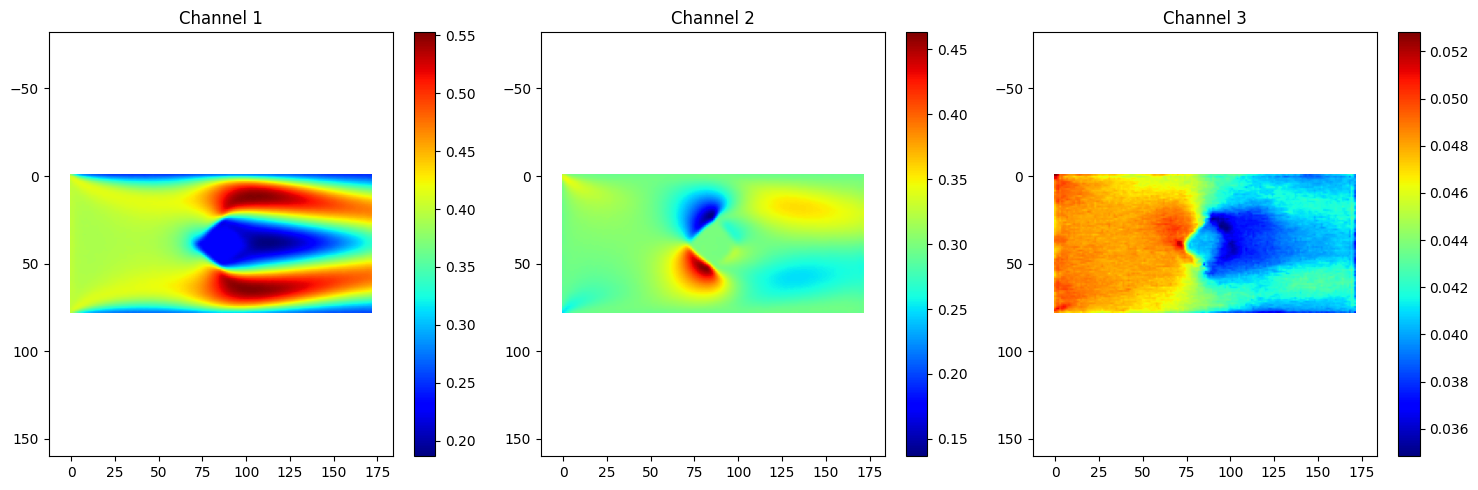

In [11]:
denoised_history = []
with torch.no_grad():
    input = torch.randn((1, 3, 128, 128)).to("cuda")
    # Run the model in evaluation
    # roll out diffuser
    for t in tqdm.tqdm(noise_scheduler.timesteps):
        noisy_residual = model(input, t).sample
        previous_noisy_sample = noise_scheduler.step(noisy_residual, t, input)
        input = previous_noisy_sample.prev_sample
        denoised_history.append(previous_noisy_sample.pred_original_sample.cpu())

plot_sample(input)


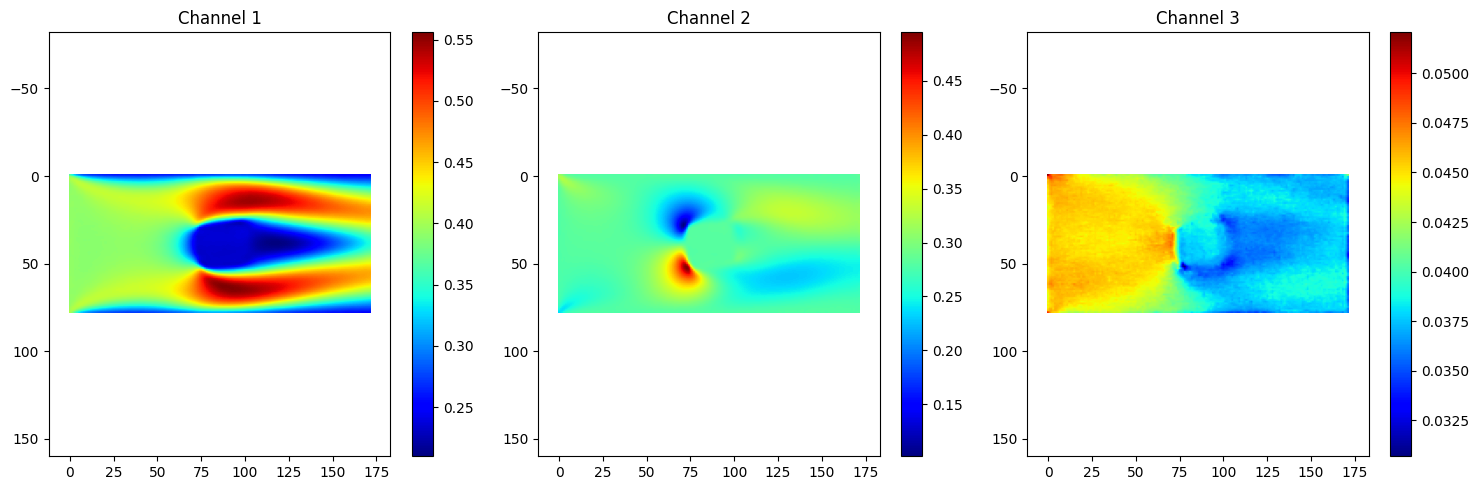

In [75]:
intermediate_step = -1
plot_sample(denoised_history[intermediate_step])